In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from collections import deque

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torch.nn as nn
# from torchvision.models import vgg16
from torchvision.models import resnext50_32x4d
import torch.optim as optim

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, precision_recall_fscore_support
from skmultilearn.model_selection import iterative_train_test_split

In [2]:
dir_data = '/kaggle/input/spongebob-classification'

In [3]:
print('GPU Available:', torch.cuda.is_available())
print('GPU Name:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU')

GPU Available: True
GPU Name: Tesla T4


In [4]:
folders = os.listdir(dir_data)
folders.remove('train.csv')
len(folders)

197

In [5]:
df = pd.read_csv(f'{dir_data}/train.csv')
df.head()

,image_path,spongebob,squidward,patrick
0,S02E01a\scene_0001.jpg,1,0,0
1,S02E01a\scene_0002.jpg,0,0,0
2,S02E01a\scene_0003.jpg,1,0,0
3,S02E01a\scene_0004.jpg,0,0,1
4,S02E01a\scene_0005.jpg,1,0,1


In [6]:
df_test = pd.read_csv('/kaggle/input/test-spongebob-csv/test_spongebob.csv')
df_test.head()

,image_path,spongebob,squidward,patrick
0,S01E01a\scene_0001.jpg,0,0,0
1,S01E01a\scene_0002.jpg,0,0,0
2,S01E01a\scene_0003.jpg,0,0,0
3,S01E01a\scene_0004.jpg,0,0,0
4,S01E01a\scene_0005.jpg,0,0,0


In [7]:
df['image_path'] = df['image_path'].str.replace('\\', '/', regex=False)
df_test['image_path'] = df_test['image_path'].str.replace('\\', '/', regex=False)

In [8]:
trial_num = '10'
label_cols = ['spongebob', 'squidward', 'patrick']
image_size = 224
batch_size = 32
num_epochs = 60
learning_rate = 2e-4
thresholds = {'spongebob': 0.4, 'squidward': 0.4, 'patrick': 0.6}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def smooth_labels(labels, smoothing=0.05):
    return labels * (1 - smoothing) + 0.5 * smoothing

In [10]:
transform_light = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.2))
])

In [11]:
transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [12]:
class SpongebobDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, train=True, smoothing=0.1):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.smoothing = smoothing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['image_path'])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = row[label_cols].values.astype('float32')
        if self.train:
            label = smooth_labels(label, smoothing=self.smoothing)
        return image, torch.tensor(label)

In [13]:
# train_df = df.sample(frac=0.8, random_state=42)
# val_df = df.drop(train_df.index)

In [14]:
X = df[['image_path']].values
y = df[label_cols].values

X_train, y_train, X_val, y_val = iterative_train_test_split(X, y, test_size=0.2)

train_df = pd.DataFrame(X_train, columns=['image_path'])
train_df[label_cols] = y_train
val_df = pd.DataFrame(X_val, columns=['image_path'])
val_df[label_cols] = y_val

train_df['label_sum'] = train_df[label_cols].sum(axis=1)
df_empty = train_df[train_df['label_sum'] == 0].sample(frac=0.2, random_state=42)
df_nonempty = train_df[train_df['label_sum'] > 0]

df_sponge_only = df_nonempty[
    (df_nonempty['spongebob'] == 1) &
    (df_nonempty['squidward'] == 0) &
    (df_nonempty['patrick'] == 0)
].sample(frac=0.7, random_state=42)

df_rest = df_nonempty.drop(df_sponge_only.index)
train_df = pd.concat([df_rest, df_sponge_only, df_empty]).sample(frac=1, random_state=42).reset_index(drop=True)
train_df.drop(columns='label_sum', inplace=True)

In [15]:
# train_ds = SpongebobDataset(train_df, dir_data, transform=transform_train)
# val_ds = SpongebobDataset(val_df, dir_data, transform=transform_test, train=False)

# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [16]:
model = resnext50_32x4d(weights=None)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 3)
)
model = model.to(device)

In [17]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probas = torch.sigmoid(logits)
        focal_weight = self.alpha * (1 - probas) ** self.gamma * targets + \
                       (1 - self.alpha) * probas ** self.gamma * (1 - targets)
        return (focal_weight * bce_loss).mean()

In [18]:
label_freq = train_df[label_cols].sum()
# pos_weight = ((len(train_df) - label_freq) / label_freq).values
# pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

label_weights = 1. / label_freq
sample_weights = train_df[label_cols].dot(label_weights).values
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

pos_weight = ((len(train_df) - train_df[label_cols].sum()) / train_df[label_cols].sum()).values
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

criterion = BCEFocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)

# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-6
)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
train_losses, val_losses, f1_scores = [], [], []
train_f1_scores, val_f1_scores = [], []
train_f1_per_class, val_f1_per_class = [], []
best_f1 = 0.0
patience = 7
counter = 0
best_epoch = 0
min_delta = 0.01
val_f1_window = deque(maxlen=5)
window_delta = 0.005
start_time = time.time()

for epoch in range(num_epochs):
    print(f'\n=== Epoch {epoch+1}/{num_epochs} ===')
    epoch_start = time.time()

    if epoch < 2:
        train_ds = SpongebobDataset(train_df, dir_data, transform=transform_light)
    else:
        train_ds = SpongebobDataset(train_df, dir_data, transform=transform_train)
    val_ds = SpongebobDataset(val_df, dir_data, transform=transform_test, train=False)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    model.train()
    total_loss = 0
    train_preds, train_labels = [], []
    train_confidences = []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        probs = torch.sigmoid(outputs)
        train_confidences.append(probs.mean().item()) 
        preds = (probs > 0.5).int().cpu().numpy()
        train_preds.append(preds)
        train_labels.append((labels.cpu() > 0.5).int().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss) 
    avg_train_conf = np.mean(train_confidences)

    train_preds = np.vstack(train_preds)
    train_labels = np.vstack(train_labels)
    train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)
    train_f1_scores.append(train_f1)
    train_f1_class = precision_recall_fscore_support(train_labels, train_preds, zero_division=0)[2]
    train_f1_per_class.append(train_f1_class)

    print(f"Train Loss: {avg_train_loss:.4f} | Macro F1: {train_f1:.4f} | Avg Confidence: {avg_train_conf:.4f}")
    for i, label in enumerate(label_cols):
        print(f"Train F1 - {label}: {train_f1_class[i]:.4f}")
    
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    val_confidences = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = torch.sigmoid(outputs)
            val_confidences.append(probs.mean().item())
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().int().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss) 
    avg_val_conf = np.mean(val_confidences)
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    val_f1_scores.append(val_f1)
    val_f1_class = precision_recall_fscore_support(all_labels, all_preds, zero_division=0)[2]
    val_f1_per_class.append(val_f1_class)

    print(f"Val Loss: {avg_val_loss:.4f} | Macro F1: {val_f1:.4f} | Avg Confidence: {avg_val_conf:.4f}")
    for i, label in enumerate(label_cols):
        print(f"Val F1 - {label}: {val_f1_class[i]:.4f}")
    
    scheduler.step(val_f1)

    epoch_time = time.time() - epoch_start
    print(f'Epoch Time: {epoch_time:.2f} sec')

    val_f1_window.append(val_f1)
    if val_f1 > best_f1 + min_delta:
        best_f1 = val_f1
        best_epoch = epoch + 1
        counter = 0
        val_f1_window.clear()
        torch.save(model.state_dict(), f'/kaggle/working/trial-{trial_num}.pth') 
        print('Model Saved')
    else:
        counter += 1
        print(f'No improvement. Early stopping counter: {counter}/{patience}')
        if counter == patience:
            print(f'Early Stopping, {counter} does not give better F1-score')
            print(f'Best Val Macro F1: {best_f1:.4f} at Epoch {best_epoch}')
            break
    if len(val_f1_window) == val_f1_window.maxlen:
        if max(val_f1_window) - min(val_f1_window) < window_delta:
            print(f'Best Val Macro F1: {best_f1:.4f} at Epoch {best_epoch}')
            print("\nEarly stopping: validation F1 plateaued.")
            break
            
    print(f'Best Val Macro F1: {best_f1:.4f} at Epoch {best_epoch}')
    
total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes.")


=== Epoch 1/60 ===
Train Loss: 0.1518 | Macro F1: 0.5080 | Avg Confidence: 0.4609
Train F1 - spongebob: 0.4418
Train F1 - squidward: 0.5133
Train F1 - patrick: 0.5689
Val Loss: 0.1401 | Macro F1: 0.2983 | Avg Confidence: 0.4560
Val F1 - spongebob: 0.2024
Val F1 - squidward: 0.2773
Val F1 - patrick: 0.4151
Epoch Time: 90.25 sec
Model Saved
Best Val Macro F1: 0.2983 at Epoch 1

=== Epoch 2/60 ===
Train Loss: 0.1199 | Macro F1: 0.6427 | Avg Confidence: 0.4678
Train F1 - spongebob: 0.5974
Train F1 - squidward: 0.6457
Train F1 - patrick: 0.6851
Val Loss: 0.1550 | Macro F1: 0.4534 | Avg Confidence: 0.4970
Val F1 - spongebob: 0.6258
Val F1 - squidward: 0.2702
Val F1 - patrick: 0.4641
Epoch Time: 93.14 sec
Model Saved
Best Val Macro F1: 0.4534 at Epoch 2

=== Epoch 3/60 ===
Train Loss: 0.0979 | Macro F1: 0.7198 | Avg Confidence: 0.4713
Train F1 - spongebob: 0.6787
Train F1 - squidward: 0.7163
Train F1 - patrick: 0.7645
Val Loss: 0.1019 | Macro F1: 0.5084 | Avg Confidence: 0.4572
Val F1 - spon

In [20]:
print(classification_report(all_labels, all_preds, target_names=label_cols))

              precision    recall  f1-score   support

   spongebob       0.66      0.89      0.76       646
   squidward       0.39      0.85      0.53       231
     patrick       0.33      0.92      0.49       231

   micro avg       0.49      0.89      0.63      1108
   macro avg       0.46      0.89      0.59      1108
weighted avg       0.54      0.89      0.65      1108
 samples avg       0.42      0.42      0.42      1108



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


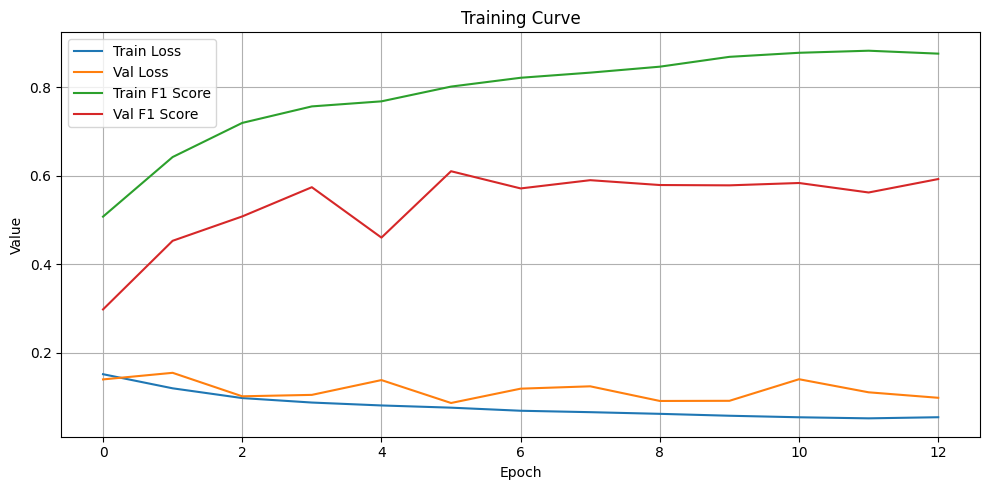

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
trial_model = resnext50_32x4d(weights=None)
in_features = trial_model.fc.in_features
trial_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 3)
)
trial_model.load_state_dict(torch.load(f'/kaggle/working/trial-{trial_num}.pth', map_location=device))

trial_model = trial_model.to(device)
trial_model.eval()

logits_val = []
labels_val = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = trial_model(imgs)
        logits_val.append(outputs.cpu())
        labels_val.append(labels)

logits_val = torch.cat(logits_val).numpy()
labels_val = torch.cat(labels_val).int().numpy()

label_cols = ['spongebob', 'squidward', 'patrick']
best_thresholds = {}
threshold_range = np.arange(0.3, 0.71, 0.01)

for i, label in enumerate(label_cols):
    best_f1 = 0
    best_t = 0.5
    for t in threshold_range:
        preds = (torch.sigmoid(torch.tensor(logits_val[:, i])) > t).int().numpy()
        f1 = f1_score(labels_val[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[label] = round(best_t, 2)

print('Best Threshold')
print(best_thresholds)

/tmp/ipykernel_19/3187173780.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trial_model.load_state_dict(torch.load(f'/kaggle/working/trial-{trial_num}.pth', map_locatio

Best Threshold
{'spongebob': 0.54, 'squidward': 0.54, 'patrick': 0.65}


In [23]:
probs_val = torch.sigmoid(torch.tensor(logits_val)).numpy()

bin_preds = np.zeros_like(probs_val)
for i, label in enumerate(label_cols):
    bin_preds[:, i] = (probs_val[:, i] > best_thresholds[label]).astype(int)

print(classification_report(labels_val, bin_preds, target_names=label_cols, zero_division=0))

              precision    recall  f1-score   support

   spongebob       0.79      0.82      0.80       646
   squidward       0.65      0.63      0.64       231
     patrick       0.78      0.65      0.71       231

   micro avg       0.76      0.74      0.75      1108
   macro avg       0.74      0.70      0.72      1108
weighted avg       0.76      0.74      0.75      1108
 samples avg       0.39      0.37      0.37      1108



In [24]:
temp_thres = {'spongebob': 0.5, 'squidward': 0.5, 'patrick': 0.5}

In [25]:
test_ds = SpongebobDataset(df_test, dir_data, transform=transform_test, train=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

submission_preds = []
image_ids = []

with torch.no_grad():
    for imgs, paths in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = np.zeros_like(probs)
        for i, label in enumerate(label_cols):
            preds[:, i] = (probs[:, i] > best_thresholds[label]).astype(int)
            # preds[:, i] = (probs[:, i] > temp_thres[label]).astype(int)
        submission_preds.extend(preds.astype(int).tolist())

submission = pd.DataFrame(submission_preds, columns=label_cols)
submission.insert(0, 'image_path', df_test['image_path'])
submission['image_path'] = submission['image_path'].str.replace('/', '\\')
submission.columns = ['image_path', 'SpongeBob', 'Squidward', 'Patrick']
submission.to_csv(f'submission_{trial_num}.csv', index=False)

In [26]:
tester = pd.read_csv(f'/kaggle/working/submission_{trial_num}.csv')
tester.head(30)

,image_path,SpongeBob,Squidward,Patrick
0,S01E01a\scene_0001.jpg,0,0,1
1,S01E01a\scene_0002.jpg,0,1,0
2,S01E01a\scene_0003.jpg,0,1,0
3,S01E01a\scene_0004.jpg,0,0,0
4,S01E01a\scene_0005.jpg,0,0,0
5,S01E01a\scene_0006.jpg,1,0,0
6,S01E01a\scene_0007.jpg,1,0,0
7,S01E01a\scene_0008.jpg,1,0,0
8,S01E01a\scene_0009.jpg,1,0,0
9,S01E01a\scene_0010.jpg,1,0,0


In [27]:
print('DONE BOSGENG')

DONE BOSGENG
